In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
import torch

In [2]:
!pip install datasets
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [4]:
train = torchvision.datasets.KMNIST(root='./data', download = True, transform = transform, train=True)

100%|██████████| 18.2M/18.2M [00:13<00:00, 1.32MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.47MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 6.68MB/s]


In [5]:
batch_size = 32
train_loader = DataLoader(train, batch_size = batch_size, shuffle = True)

In [6]:
print(train_loader.batch_size)

32


torch.Size([1, 28, 28])
tensor(2)


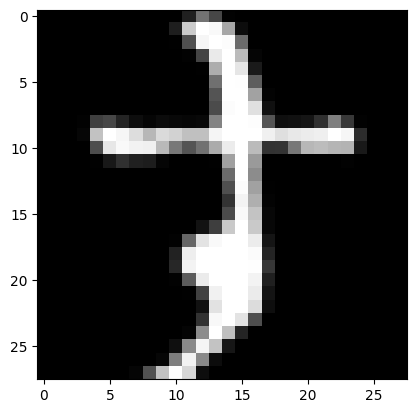

In [26]:
iter_train = iter(train_loader)

batch = next(iter_train)

image = batch[0][0]


print(image.shape)

np_img = image.numpy()

np_img = np_img.transpose(1,2,0)

plt.imshow(np_img, cmap = 'gray')




In [128]:
latent_dim = 128

import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, batch_dim, latent_dim):
        super().__init__()
        self.gen = nn.Sequential(
            # 100 --> 128,7,7
            nn.Linear(in_features = latent_dim, out_features = 128*7*7),
            nn.BatchNorm1d(128*7*7),
            nn.ReLU(True),
            nn.Unflatten(dim = 1, unflattened_size = (128,7,7)),

            # 128,7,7 --> 64,14,14
            nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride=2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 64,14,14 --> 1,28,28
            nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride=2, padding = 1),
            nn.Tanh()
        )

        self.initialize_weights()

    def forward(self, x):
        return self.gen(x)

    def initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.ConvTranspose2d):
          nn.init.kaiming_uniform_(m.weight)
        elif isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight)

In [129]:
G = Generator(32, latent_dim).to('cpu')


torch.Size([32, 1, 28, 28])


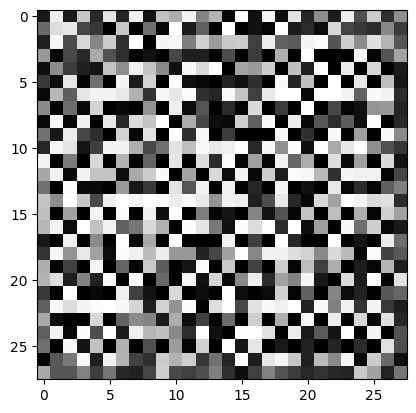

In [131]:
z = torch.randn(32, latent_dim)
fake = G(z)

print(fake.shape)


fake_img = fake[1].detach().numpy()

fake_img = fake_img.transpose(1,2,0)

plt.imshow(fake_img, cmap='gray')


In [127]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.disc = nn.Sequential(
            # 1,28,28 --> 32,14,14
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # 32,14,14 --> 64,7,7
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),

            # Last Layer
            nn.Linear(in_features = 128*7*7, out_features = 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.disc(x)
        return x

In [115]:
D = Discriminator().to('cpu')

print(D(fake).shape)

fake_probs = torch.argmax(D(fake))
print(D(fake))
print(fake_probs)


for batch in train_loader:

  images= batch[0]
  print(f'inputs shape: {images.shape}')
  images = images.type(torch.float)
  print(f'after network: {D(images).shape}')

  print()
  print()

  real_probs = torch.argmax(D(images))
  real_input = D(images)
  print(real_probs)

  real_labels = torch.full_like(real_input, 0.95)

  print(real_labels)
  print(real_input.shape)

  break

torch.Size([32, 1])
tensor([[0.5733],
        [0.6708],
        [0.3914],
        [0.3788],
        [0.3829],
        [0.3985],
        [0.6383],
        [0.4662],
        [0.6345],
        [0.5124],
        [0.5506],
        [0.4171],
        [0.4598],
        [0.4504],
        [0.4663],
        [0.5551],
        [0.4255],
        [0.4764],
        [0.6340],
        [0.6240],
        [0.4374],
        [0.4369],
        [0.4675],
        [0.3478],
        [0.3333],
        [0.4590],
        [0.4857],
        [0.5890],
        [0.3545],
        [0.4080],
        [0.3552],
        [0.7286]], grad_fn=<SigmoidBackward0>)
tensor(31)
inputs shape: torch.Size([32, 1, 28, 28])
after network: torch.Size([32, 1])


tensor(30)
tensor([[0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
        [0.9500],
    

In [116]:
g_params = 0
d_params = 0

# Discriminator Parameters
for x in D.parameters():
  d_params += len(torch.flatten(x))

print(f'Discriminator parameters: {d_params:,}')

for x in G.parameters():
  g_params += len(torch.flatten(x))

print(f'Generator parameters: {g_params:,}')




Discriminator parameters: 39,873
Generator parameters: 854,849


In [63]:
import torch.optim as optim
criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=0.0001)
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
print(len(train_loader))

1875


In [65]:
epochs = 15

for epoch in range(epochs):
  print(f'Epoch {epoch+1}')

  G.train(True)
  D.train(True)
  DRunning_loss = 0.0
  GRunning_loss = 0.0

  for index, batch in enumerate(train_loader):
    real_images = batch[0]
    real_images = real_images.to(device)
    real_images = real_images.type(torch.float)

    batch_size = real_images.shape[0]

    z = torch.randn(batch_size, latent_dim, device=device)
    fake = G(z)

    ### train discriminator ###

    #discriminate real ones
    D_optimizer.zero_grad()

    D_real = D(real_images).view(-1)
    D_loss_real = criterion(D_real, torch.full_like(D_real,0.90))

    D_fake = D(fake.detach()).view(-1)
    D_loss_fake = criterion(D_fake, torch.full_like(D_fake,0.10))

    D_loss = (D_loss_real+ D_loss_fake) / 2


    D.zero_grad()
    D_loss.backward()
    D_optimizer.step()
    DRunning_loss += D_loss.item()

    ### train generator ###
    G_optimizer.zero_grad()

    output = D(fake)
    G_loss = criterion(output, torch.ones_like(output))

    G_loss.backward()
    G_optimizer.step()

    GRunning_loss+=G_loss.item()

    if (index % 25 == 24):
      print(f'Batch: {index+1}   D_Loss: {DRunning_loss/25:.3f}   G_Loss: {GRunning_loss/25:.3f}')
      DRunning_loss = 0.0
      GRunning_loss = 0.0

with (open('G.pt', 'wb')) as f:
  torch.save(G.state_dict(), f)

with (open('D.pt', 'wb')) as f:
  torch.save(D.state_dict(), f)

print('Finished Training')

Epoch 1
Batch: 25   D_Loss: 0.706   G_Loss: 0.708
Batch: 50   D_Loss: 0.697   G_Loss: 0.723
Batch: 75   D_Loss: 0.692   G_Loss: 0.721
Batch: 100   D_Loss: 0.686   G_Loss: 0.726
Batch: 125   D_Loss: 0.682   G_Loss: 0.734
Batch: 150   D_Loss: 0.678   G_Loss: 0.739
Batch: 175   D_Loss: 0.673   G_Loss: 0.748
Batch: 200   D_Loss: 0.669   G_Loss: 0.759
Batch: 225   D_Loss: 0.662   G_Loss: 0.768
Batch: 250   D_Loss: 0.659   G_Loss: 0.776
Batch: 275   D_Loss: 0.651   G_Loss: 0.793
Batch: 300   D_Loss: 0.646   G_Loss: 0.802
Batch: 325   D_Loss: 0.644   G_Loss: 0.814
Batch: 350   D_Loss: 0.642   G_Loss: 0.823
Batch: 375   D_Loss: 0.633   G_Loss: 0.838
Batch: 400   D_Loss: 0.627   G_Loss: 0.851
Batch: 425   D_Loss: 0.621   G_Loss: 0.864
Batch: 450   D_Loss: 0.625   G_Loss: 0.869
Batch: 475   D_Loss: 0.619   G_Loss: 0.887
Batch: 500   D_Loss: 0.615   G_Loss: 0.886
Batch: 525   D_Loss: 0.606   G_Loss: 0.907
Batch: 550   D_Loss: 0.605   G_Loss: 0.924
Batch: 575   D_Loss: 0.601   G_Loss: 0.931
Batch:

In [132]:

with open('G.pt','rb') as f:
  G.load_state_dict(torch.load(f))

  z = torch.randn(32,latent_dim)

  fake = G(z)

  print(fake.shape)


  fake_img = fake[0].detach().numpy()

  fake_img = fake_img.transpose(1,2,0)
  plt.imshow(fake_img, cmap='gray')

RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for gen.4.weight: copying a param with shape torch.Size([128, 64, 2, 2]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for gen.7.weight: copying a param with shape torch.Size([64, 1, 2, 2]) from checkpoint, the shape in current model is torch.Size([64, 1, 4, 4]).

In [86]:
!pip install tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import sys

writer = SummaryWriter("runs")

In [ ]:
img_grid = torchvision.utils.make_grid()
writer.add_image(f'batch {batch+1} generated images:', img_grid)